# Training a regression with outputs shaped by Guassian

Use pytorch to take into account the correlation during the training, and force the output distributions to be shaped by a Gaussian.

## Settings

In [1]:
n_variables = 4 # Number of data and background varialbes to generate
n_samples = 10000 # Number of samples to generate

center_signal = 2.0 # Where the gaussian for signal should be
center_background = 1.0 # Where the gaussian for background should be

In [2]:
import sys
sys.path += ['../abcdlib']
import data_gen

import seaborn as sns
import pandas as pd
from torch import nn
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt

## Generate the data

In [3]:
sig = data_gen.generate_gaussian(n_variables, center_signal, n_samples)
back = data_gen.generate_gaussian(n_variables, center_background, n_samples)

n_training_samples = int(n_samples/2)

training = data_gen.combine(sig[:n_training_samples], back[:n_training_samples])
testing = data_gen.combine(sig[n_training_samples:], back[n_training_samples:])

## Train with two outputs and a custom loss function

For a regression, we need just a single output column with the 1 or 0 as the target value. Of course, this time we need 2 columns, duplicated.

In [4]:
label = training[training.columns[-1]].values
labels = np.stack((label, label), axis=1)

In [5]:
x_train = torch.Tensor(training[training.columns[:-1]].values)
y_train = torch.Tensor(labels)

The loss function should be a combination of the normal accuracy loss function and also the correlation on background (only), and shape the background to look like a Guassian (also only on the background).

- Use the accuracy on all the training data
- Calculate the correlation only on items marked as being background
- Turn the background variable distirbution into a z-scoare, and then match it to a guassian curve we have pre-generated.

In [6]:
def calc_r(prediction):
    mean = torch.mean(prediction, dim=0)
    std_dev = torch.std(prediction, dim=0)
    parts = (prediction - mean)
    sum = torch.sum(parts[:,0]*parts[:,1])
    return sum / std_dev[0] / std_dev[1] / (prediction.shape[0]-1)

class decorrelate_loss:
    '''Calculate the loss function using MSELoss and decorrelation loss
    '''
    def __init__(self):
        self._mse = nn.MSELoss(reduction='mean')
        self._unit_gaussian, _ = torch.sort(torch.randn((n_training_samples, 2)), dim=0)
        self._loss_record = []
        
    def calc_gausian_shape_difference(self, background):
        # Turn background into z score
        mean = torch.mean(background, dim=0)
        std_dev = torch.std(background, dim=0)
        z_score, _ = torch.sort((background - mean)/std_dev, dim=0)
        
        return self._mse(z_score, self._unit_gaussian)

    def __call__(self, prediction, labels):
        'Calc the loss given both the correlation and mse'
        mse_loss = self._mse(prediction, labels)
        
        background_mask = labels[:,1] == 0
        r = calc_r(prediction[background_mask])
        
        g_background = self.calc_gausian_shape_difference(prediction[background_mask])
        
        total = mse_loss + torch.square(r)*2.0 + g_background
        self._loss_record.append((float(mse_loss.item()),
                                  float((torch.square(r)*2.0).item()),
                                  float(g_background.item())))
        # print (mse_loss, torch.square(r), g_background)
        # print(total)
        return total

Next create a simple classifier - 2 layers, with the same number of nodes as inputs. It looks like doubling the size of the inputs and outputs makes a big difference, but in general getting this to train better hasn't been successful so far. No idea why.

In [7]:
model = nn.Sequential(nn.Linear(n_variables, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables),
                      nn.ReLU(),
                      nn.Linear(n_variables, 2))
criterion = decorrelate_loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now lets do the training

In [ ]:
%%time
epochs = 200000
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if e % 300 == 0:
        print(f'Training loss ({e}): {running_loss/len(x_train)}')
else:
    print(f'Training loss: {running_loss/len(x_train)}')

Training loss (0): 0.00024330005645751952
Training loss (300): 2.5428345799446106e-05
Training loss (600): 2.511032819747925e-05
Training loss (900): 2.5059401988983156e-05
Training loss (1200): 2.5029560923576356e-05
Training loss (1500): 2.5006169080734254e-05
Training loss (1800): 2.4989017844200134e-05
Training loss (2100): 2.4958032369613646e-05
Training loss (2400): 2.4938005208969118e-05
Training loss (2700): 2.4912528693675995e-05
Training loss (3000): 2.4876262247562408e-05
Training loss (3300): 2.481551915407181e-05
Training loss (3600): 2.4719007313251494e-05
Training loss (3900): 2.4527041614055633e-05
Training loss (4200): 2.408613860607147e-05
Training loss (4500): 2.2371934354305267e-05
Training loss (4800): 2.0568951964378356e-05
Training loss (5100): 1.8836931884288787e-05
Training loss (5400): 1.776551008224487e-05
Training loss (5700): 1.5591739118099214e-05
Training loss (6000): 1.4497809112071991e-05
Training loss (6300): 1.4247527718544006e-05
Training loss (6600)

In [17]:
loss_info_mse = [
    {
        'loss': mse,
        'type': 'mse',
        'epoch': i
    }
    for i, (mse, corr, gaus) in enumerate(criterion._loss_record)
]
loss_info_corr = [
    {
        'loss': corr,
        'type': 'correlation',
        'epoch': i
    }
    for i, (mse, corr, gaus) in enumerate(criterion._loss_record)
]
loss_info_gauss = [
    {
        'loss': gaus,
        'type': 'gaussian',
        'epoch': i
    }
    for i, (mse, corr, gaus) in enumerate(criterion._loss_record)
]
loss_trends = pd.DataFrame(loss_info_mse + loss_info_corr + loss_info_gauss)

,loss,type,epoch
0,0.383826,mse,0
1,0.381497,mse,1
2,0.379424,mse,2
3,0.377231,mse,3
4,0.375615,mse,4
...,...,...,...
599995,0.000784,gaussian,199995
599996,0.000763,gaussian,199996
599997,0.000760,gaussian,199997
599998,0.000772,gaussian,199998


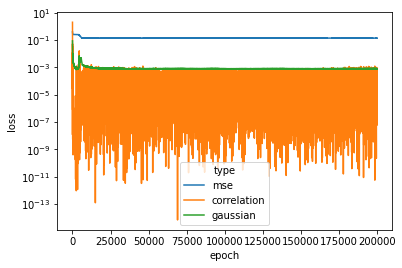

In [26]:
_ = sns.lineplot(x='epoch', y='loss', hue='type', data=loss_trends)
plt.yscale('log')

## Prediction

Get the predicted probabilities out and see where they line up and how well this guy did!

In [19]:
x_test = torch.Tensor(testing[testing.columns[:-1]].values)
y_test = model(x_test)

In [20]:
x_results = testing.copy()
x_results['Prediction_1'] = y_test.detach().numpy()[:,0]
x_results['Prediction_2'] = y_test.detach().numpy()[:,1]

<AxesSubplot:xlabel='Prediction_1', ylabel='Count'>

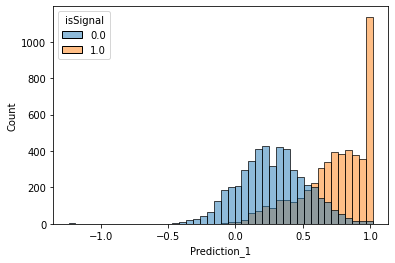

In [21]:
sns.histplot(x_results, x='Prediction_1', hue='isSignal')

<AxesSubplot:xlabel='Prediction_2', ylabel='Count'>

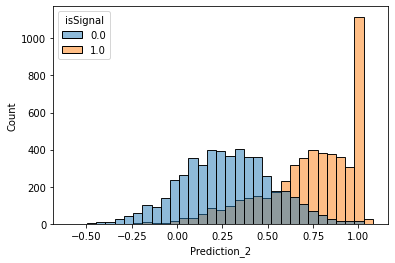

In [22]:
sns.histplot(x_results, x='Prediction_2', hue='isSignal')

Lets look at the correlation between these on background and signal data

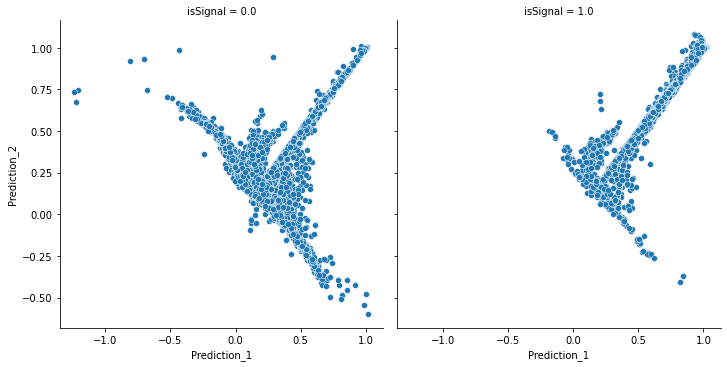

In [23]:
sns.relplot(data=x_results, x='Prediction_1', y='Prediction_2', col='isSignal')

Other than something odd going on down near zero, this looks very correlated for background (and signal). We need the background to be uncorrelated...

## Correlation for the background

Lets see what the final number of the correlation is of the background

In [24]:
label = torch.Tensor(testing[testing.columns[-1]].values)
mask = label == 0.0
calc_r(y_test[mask])

tensor(0.0466, grad_fn=<DivBackward0>)